# Geometric Brownian Motion Demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/QMCSoftware/QMCSoftware/blob/geometric_brownian_motion/demos/gbm_demo.ipynb)

Larysa Matiukha and Sou-Cheng T. Choi

Illinois Institute of Technology

Modification date: 06/28/2025

Creation date: 08/24/2024

In [1]:
import qmcpy as qp
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
import ipywidgets as widgets

Geometric Brownian motion (GBM) is a continuous stochastic process in which the natural logarithm of its values follows a Brownian motion. $[1]$

Mathematically, it can be defined as follows:

$\large{S_t = S_0 \, e^{\big(\mu - \frac{\sigma^2}{2}\big)  t + \sigma W_t}}$, 

where
* $S_0$ is the initial value, 
* $\mu$ is a drift coefficient
* $\sigma$ is difussion coefficient  
* $W_t$ is a (standard) Brownian motion.

GBM is commonly used to model stock prices and options payoffs. 

## GBM object in QMCPy

Geometric Brownian Motion in QMCPy inherits from BrownianMotion class $[2, 3]$. 

Let's explore the constructor and sample generation methods through the built-in help documentation:

In [2]:
help(qp.GeometricBrownianMotion.__init__)

Help on function __init__ in module qmcpy.true_measure.geometric_brownian_motion:

__init__(self, sampler, t_final=1, initial_value=1, drift=0, diffusion=1, decomp_type='PCA')
    GeometricBrownianMotion(t) = initial_value * exp[(drift - 0.5 * diffusion) * t
                                                     + \sqrt{diffusion} * StandardBrownianMotion(t)]
    
    Args:
        sampler (DiscreteDistribution/TrueMeasure): A discrete distribution or true measure.
        t_final (float): End time for the geometric Brownian motion, non-negative.
        initial_value (float): Positive initial value of the process.
        drift (float): Drift coefficient.
        diffusion (float): Diffusion coefficient, positive.
        decomp_type (str): Method of decomposition, either "PCA" or "Cholesky".



In [3]:
help(qp.GeometricBrownianMotion.gen_samples)

Help on function gen_samples in module qmcpy.true_measure._true_measure:

gen_samples(self, *args, **kwargs)
    Generate samples from the discrete distribution
    and transform them via the transform method. 
    
    Args:
        args (tuple): positional arguments to the discrete distributions gen_samples method
        kwargs (dict): keyword arguments to the discrete distributions gen_samples method
    
    Returns: 
        ndarray: n x d matrix of transformed samples



Now let's create a simple GBM instance and generate sample paths to see the class in action:

In [4]:
gbm = qp.GeometricBrownianMotion(qp.Lattice(2)) 
gbm

GeometricBrownianMotion (TrueMeasure Object)
    time_vec        [0.5 1. ]
    drift           0
    diffusion       1
    mean_gbm        [1. 1.]
    covariance_gbm  [[0.649 0.649]
                    [0.649 1.718]]
    decomp_type     PCA

In [5]:
gbm.gen_samples(n=4) # generates four 2-dimensional samples

array([[0.48086533, 0.16745019],
       [0.70946687, 0.96659803],
       [1.35699476, 0.27471775],
       [1.50075457, 1.83151594]])

### Log-Normality Property

At any time $t > 0$, $S_t$ follows a log-normal distribution with expected value and variance as follows (see Section 3.2 in $[1]$):

- $E[S_t] = S_0 e^{\mu t}$
- $\text{Var}[S_t] = S_0^2 e^{2\mu t}(e^{\sigma^2 t} - 1)$

Let's validate these theoretical properties by generating a large number of GBM samples and comparing the empirical moments with the theoretical values. Note that the theoretical values match the last values in `qp_gbm.mean_gbm` and `qp_gbm.covariance_gbm` for the final time point.

In [6]:
# Generate GBM samples for theoretical validation
S0, mu, sigma, T, n_samples = 100.0, 0.05, 0.20, 1.0, 2**12
sampler = qp.Lattice(5, seed=42)
qp_gbm = qp.GeometricBrownianMotion(sampler, t_final=T, initial_value=S0, drift=mu, diffusion=sigma)
paths = qp_gbm.gen_samples(n_samples)
S_T = paths[:, -1]  # Final values only

# Calculate theoretical vs empirical sample moments
theo_mean = S0 * np.exp(mu * T)
theo_var = S0**2 * np.exp(2*mu*T) * (np.exp(sigma**2 * T) - 1)
qp_emp_mean = np.mean(S_T)
qp_emp_var = np.var(S_T, ddof=1) 
print(f"Mean: {qp_emp_mean:.3f} (theoretical: {theo_mean:.3f})")
print(f"Variance: {qp_emp_var:.3f} (theoretical: {theo_var:.3f})")
qp_gbm

Mean: 105.134 (theoretical: 105.127)
Variance: 453.062 (theoretical: 451.029)


GeometricBrownianMotion (TrueMeasure Object)
    time_vec        [0.2 0.4 0.6 0.8 1. ]
    drift           0.050
    diffusion       0.200
    mean_gbm        [101.005 102.02  103.045 104.081 105.127]
    covariance_gbm  [[ 81.943  82.767  83.599  84.439  85.288]
                    [ 82.767 167.869 169.556 171.26  172.981]
                    [ 83.599 169.556 257.923 260.516 263.134]
                    [ 84.439 171.26  260.516 352.258 355.798]
                    [ 85.288 172.981 263.134 355.798 451.029]]
    decomp_type     PCA

## GMB vs Brownian Motion

Below we compare Brownian motion and geometric Brownian motion using the same parameters: `drift` = 0, `diffusion` = 1, `initial_value` = 1.


First, let's define a utility function that will help us visualize GBM paths with different samplers and parameters:

In [7]:
def plot_paths(motion_type, sampler, t_final, initial_value, drift, diffusion, n):
    if motion_type.upper() == 'BM':
        motion = qp.BrownianMotion(sampler, t_final, initial_value, drift, diffusion)
        title = f'Realizations of Brownian Motion using {type(sampler).__name__} points'
        ylabel = 'W(t)'
    elif motion_type.upper() == 'GBM':
        motion = qp.GeometricBrownianMotion(sampler, t_final, initial_value, drift, diffusion)
        title = f'Realizations of Geometric Brownian Motion using {type(sampler).__name__} points'
        ylabel = 'S(t)'
    else:
        raise ValueError("motion_type must be 'BM' or 'GBM'")
    
    t = motion.gen_samples(n)
    initial_values = np.full((n, 1), motion.initial_value)
    t_w_init = np.hstack((initial_values, t))
    tvec_w_0 = np.hstack(([0], motion.time_vec))

    plt.figure(figsize=(7, 4));
    plt.plot(tvec_w_0, t_w_init.T); 
    plt.title(title);
    plt.xlabel('t');
    plt.ylabel(ylabel);
    plt.xlim([tvec_w_0[0], tvec_w_0[-1]]);
    plt.show();


Paths of the driftless Brownian motion should fluctuate symmetrically around the initial value (y = 1) and can take negative values, while those of Geometric Brownian Motion remain strictly positive.

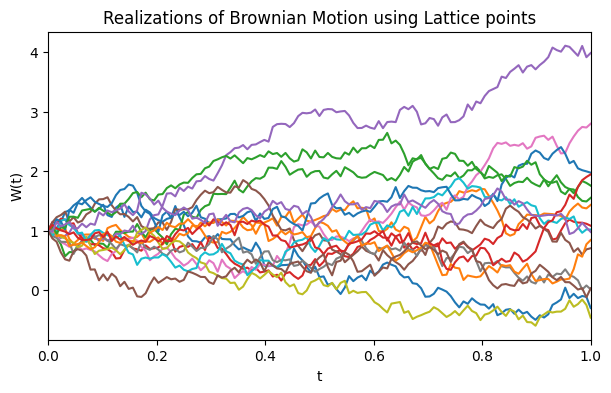

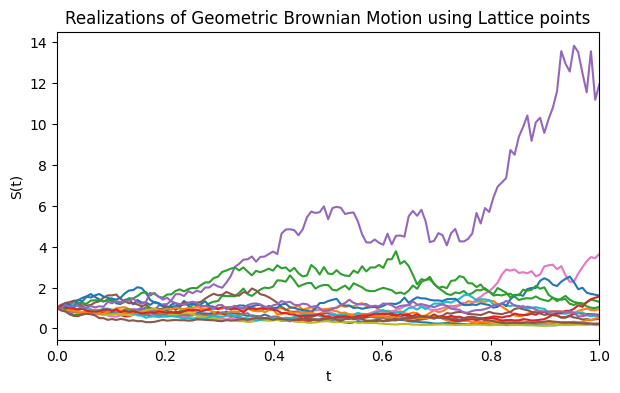

In [8]:
# Compare Brownian Motion and Geometric Brownian Motion using the unified plotting function
n = 16
sampler = qp.Lattice(2**7)
plot_paths('BM', sampler, t_final=1, initial_value=1, drift=0, diffusion=1, n=n)
plot_paths('GBM', sampler, t_final=1, initial_value=1, drift=0, diffusion=1, n=n)

Now, using `plot_gbm_paths`, we generate 32 GBM paths to model stock price, $S(t)$, with initial value $S_0$ = 50, drift coeffient, $\mu = 0.1$, diffusion coefficient $\sigma = 0.2$ using IID points.

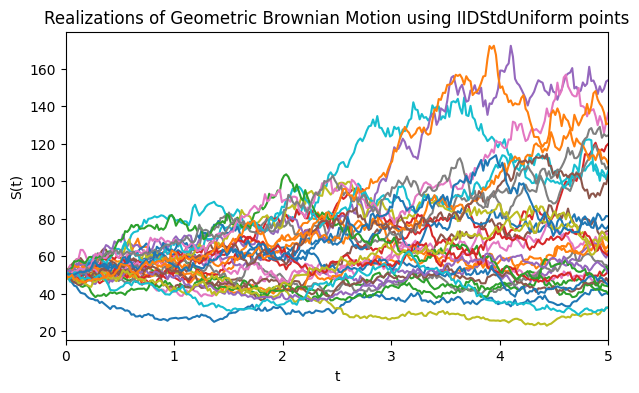

In [9]:
gbm_iid = plot_paths('GBM', qp.IIDStdUniform(2**8), t_final=5, initial_value=50, drift=0.1, diffusion=0.2, n=32)

## GBM Using Low-Discrepancy Lattice Sequence Distrubtion 

Using the same parameter values as in example above, we generate 32 GBM paths to model stock price using low-discrepancy lattice points:

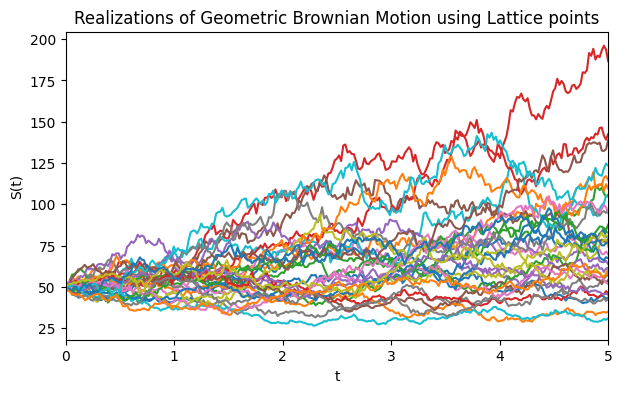

In [10]:
gbm_lattice = plot_paths('GBM', qp.Lattice(2**8), t_final=5, initial_value=50, drift=0.1, diffusion=0.2, n=32)

Next, we define a more sophisticated visualization function that combines path plotting with statistical analysis by showing both the GBM trajectories and the distribution of final values:

In [11]:

def plot_gbm_paths_with_distribution(N, sampler, t_final, initial_value, drift, diffusion,n):
    gbm = qp.GeometricBrownianMotion(sampler, t_final=t_final, initial_value=initial_value, drift=drift, diffusion=diffusion)
    gbm_path = gbm.gen_samples(2**n)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    T = max(gbm.time_vec)
    
    # Plot GBM paths
    ax.plot(gbm.time_vec, gbm_path.T, lw=0.75, alpha=0.7, color='skyblue')
    
    # Set up main plot
    ax.set_title(f'Geometric Brownian Motion Paths\n{N} Simulations, T = {T}, $\mu$ = {drift:.1f}, $\sigma$ = {diffusion:.1f}, using {type(sampler).__name__} points')
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$S(t)$')
    ax.set_ylim(bottom=0)
    ax.set_xlim(0, T)
    
    # Add histogram
    final_values = gbm_path[:, -1]
    hist_ax = ax.inset_axes([1.05, 0., 0.5, 1])
    hist_ax.hist(final_values, bins=20, density=True, alpha=0.5, color='skyblue', orientation='horizontal')
    
    # Add theoretical lognormal PDF
    shape, _, scale = sc.lognorm.fit(final_values, floc=0)
    x = np.linspace(0, max(final_values), 1000)
    pdf = sc.lognorm.pdf(x, shape, loc=0, scale=scale)
    hist_ax.plot(pdf, x, 'r-', lw=2, label='Lognormal PDF')
    
    # Finalize histogram
    hist_ax.set_title(f'E[$S_T$] = {np.mean(final_values):.2f}', pad=20)
    hist_ax.axhline(np.mean(final_values), color='blue', linestyle='--', lw=1.5, label=r'$E[S_T]$')
    hist_ax.set_yticks([])
    hist_ax.set_xlabel('Density')
    hist_ax.legend()
    hist_ax.set_ylim(bottom=0)
    
    plt.tight_layout()  
    plt.show();

## Interactive Visualization

The following code defines a set of sliders to control parameters for simulating paths of GBM. It sets the machine epsilon (eps) as the minimum value for `initial_value`,  `t_final`, and `diffusion`, ensuring they are always positive.  The function `plot_gbm_paths_with_distribution` then visualizes the GBM paths based on the specified parameters in the left subplot and fits a lognormal distribution to the histogram of the data values at the final time point in the right subplot.

In [12]:
eps = np.finfo(float).eps
slider_style = {'handle_color': 'blue'}

@widgets.interact
def f(n=widgets.IntSlider(min=0, max=8, step=1, value=7, style=slider_style),
      t_final=widgets.FloatSlider(min=eps, max=10, step=0.1, value=5.0, style=slider_style),
      initial_value=widgets.FloatSlider(min=eps, max=100, step=0.1, value=40, style=slider_style),
      drift=widgets.FloatSlider(min=-2, max=2, step=0.1, value=0.1, style=slider_style),
      diffusion=widgets.FloatSlider(min=eps, max=4, step=0.1, value=0.2, style=slider_style),
      sampler=widgets.Dropdown(options=['IIDStdUniform', 'Lattice','Halton','Sobol'], value='IIDStdUniform', description='Sampler')
):
      # Create sampler instance
      if sampler == 'IIDStdUniform':
            sampler_instance = qp.IIDStdUniform(2**n, seed=7)
      elif sampler == 'Lattice':
            sampler_instance = qp.Lattice(2**n, seed=7)
      elif sampler == 'Halton':
            sampler_instance = qp.Halton(2**n, seed=7)
      elif sampler == 'Sobol':
            sampler_instance = qp.Sobol(2**n, seed=7)

      # Call plotting function with error handling
      plot_gbm_paths_with_distribution(2**n, sampler_instance, t_final=t_final, 
                                    initial_value=initial_value, drift=drift, 
                                    diffusion=diffusion, n=n)

interactive(children=(IntSlider(value=7, description='n', max=8, style=SliderStyle(handle_color='blue')), Floa…

## QuantLib vs QMCPy Comparison

In this section, we compare QMCPy's GeometricBrownianMotion implementation with the industry-standard QuantLib library [6] to validate its accuracy and performance.

In [13]:
try:
    import QuantLib as ql
except ModuleNotFoundError:
    !pip install -q QuantLib==1.38

In [14]:
import QuantLib as ql
import time

def generate_quantlib_paths(initial_value, mu, sigma, maturity, n_steps, n_paths):
    """Generate GBM paths using QuantLib"""
    process = ql.GeometricBrownianMotionProcess(initial_value, mu, sigma)
    rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(n_steps, ql.UniformRandomGenerator()))
    sequence_gen = ql.GaussianPathGenerator(process, maturity, n_steps, rng, False)
    start_time = time.time()
    paths = np.zeros((n_paths, n_steps + 1))
    for i in range(n_paths):
        sample_path = sequence_gen.next().value()
        paths[i, :] = np.array([sample_path[j] for j in range(n_steps + 1)])
    generation_time = time.time() - start_time
    return paths, generation_time

def generate_qmcpy_paths(initial_value, mu, sigma, maturity, n_steps, n_paths):
    """Generate GBM paths using QMCPy"""
    sampler = qp.Sobol(n_steps, seed=42)
    gbm = qp.GeometricBrownianMotion(sampler, t_final=maturity, initial_value=initial_value, drift=mu, diffusion=sigma)
    start_time = time.time()
    paths = gbm.gen_samples(n_paths)
    generation_time = time.time() - start_time
    return paths, generation_time

def compute_theoretical_covariance(S0, mu, sigma, t1, t2):
    """Compute theoretical covariance matrix for GBM at two time points"""
    return np.array([
        [S0**2 * np.exp(2*mu*t1) * (np.exp(sigma**2 * t1) - 1), 
         S0**2 * np.exp(mu*(t1+t2)) * (np.exp(sigma**2 * t1) - 1)],
        [S0**2 * np.exp(mu*(t1+t2)) * (np.exp(sigma**2 * t1) - 1), 
         S0**2 * np.exp(2*mu*t2) * (np.exp(sigma**2 * t2) - 1)]
    ])

def extract_covariance_samples(paths, n_steps, is_quantlib=True):
    """Extract samples at two time points and compute covariance matrix"""
    if is_quantlib:
        idx1, idx2 = int(0.5 * n_steps), n_steps
        samples_t1, samples_t2 = paths[:, idx1], paths[:, idx2]
    else:  # QMCPy
        idx1, idx2 = int(0.5 * (n_steps - 1)), n_steps - 1
        samples_t1, samples_t2 = paths[:, idx1], paths[:, idx2]
    return np.cov(np.vstack((samples_t1, samples_t2)))

# Parameters for GBM comparison
params = {'initial_value': 100, 'mu': 0.05, 'sigma': 0.2, 'maturity': 1.0, 'n_steps': 252, 'n_paths': 2**14}

# Generate paths for both libraries
quantlib_paths, quantlib_time = generate_quantlib_paths(**params)
qmcpy_paths, qmcpy_time = generate_qmcpy_paths(**params)

# Compute covariance matrices
quantlib_cov = extract_covariance_samples(quantlib_paths, params['n_steps'], is_quantlib=True)
qmcpy_cov = extract_covariance_samples(qmcpy_paths, params['n_steps'], is_quantlib=False)
theoretical_cov = compute_theoretical_covariance(params['initial_value'], params['mu'], params['sigma'], 0.5, 1.0)

# Final value statistics
quantlib_final, qmcpy_final = quantlib_paths[:, -1], qmcpy_paths[:, -1]
theoretical_mean = params['initial_value'] * np.exp(params['mu'] * params['maturity'])
theoretical_std = np.sqrt(params['initial_value']**2 * np.exp(2*params['mu']*params['maturity']) * 
                         (np.exp(params['sigma']**2 * params['maturity']) - 1))

# Display results
print("COMPARISON: QuantLib vs QMCPy GeometricBrownianMotion")
print("="*55)
print(f"\nQuantLib sample covariance matrix:\n{quantlib_cov}")
print(f"\nQMCPy sample covariance matrix:\n{qmcpy_cov}")
print(f"\nTheoretical covariance matrix:\n{theoretical_cov}")

print("\nFINAL VALUE STATISTICS (t=1 year)")
print("-"*35)
for name, final_vals in [("QuantLib", quantlib_final), ("QMCPy", qmcpy_final)]:
    print(f"{name:<12} Mean: {np.mean(final_vals):.2f}, Empirical Std: {np.std(final_vals, ddof=1):.2f}")
print(f"{'Theoretical':<12} Mean: {theoretical_mean:.2f}, Theoretical Std: {theoretical_std:.2f}")

print("\nPERFORMANCE COMPARISON")
print("-"*25)
print(f"QuantLib generation time: {quantlib_time:.3f} seconds")
print(f"QMCPy generation time:    {qmcpy_time:.3f} seconds")
speedup = quantlib_time / qmcpy_time if quantlib_time > qmcpy_time else qmcpy_time / quantlib_time
faster_lib = "QMCPy" if quantlib_time > qmcpy_time else "QuantLib"
print(f"{faster_lib} is {speedup:.1f}x faster")

# Store variables for visualization cell (extract individual values from params)
cov_matrix, qmcpy_cov_matrix = quantlib_cov, qmcpy_cov
paths, qmcpy_paths = quantlib_paths, qmcpy_paths
initial_value = params['initial_value']
mu = params['mu']
sigma = params['sigma']
maturity = params['maturity']
n_steps = params['n_steps']

COMPARISON: QuantLib vs QMCPy GeometricBrownianMotion

QuantLib sample covariance matrix:
[[210.77139535 215.02212498]
 [215.02212498 445.4730464 ]]

QMCPy sample covariance matrix:
[[212.4331126  217.96071972]
 [217.96071972 451.36021415]]

Theoretical covariance matrix:
[[212.37084878 217.74704241]
 [217.74704241 451.02880782]]

FINAL VALUE STATISTICS (t=1 year)
-----------------------------------
QuantLib     Mean: 105.10, Empirical Std: 21.11
QMCPy        Mean: 105.13, Empirical Std: 21.25
Theoretical  Mean: 105.13, Theoretical Std: 21.24

PERFORMANCE COMPARISON
-------------------------
QuantLib generation time: 0.817 seconds
QMCPy generation time:    0.270 seconds
QMCPy is 3.0x faster


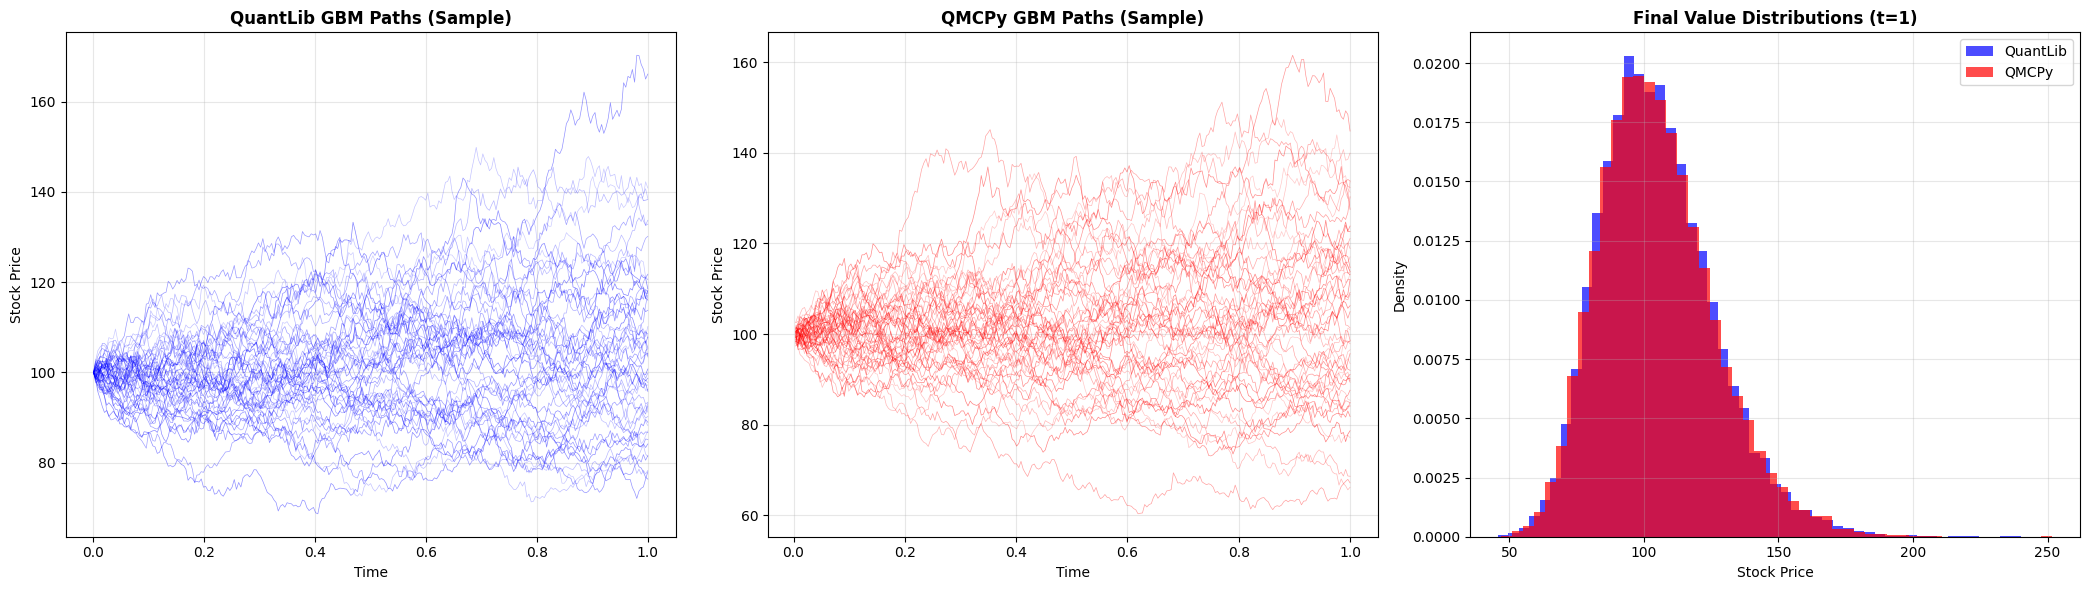

In [15]:
# Visualization 
def plot_paths_on_axis(ax, time_vec, paths_data, title, color, n_plot=50):
    """Helper function to plot GBM paths on a given axis"""
    for i in range(min(n_plot, paths_data.shape[0])):
        ax.plot(time_vec, paths_data[i, :], alpha=0.2 + 0.3 * (i / n_plot), color=color, linewidth=0.5)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('Stock Price')
    ax.grid(True, alpha=0.3)

# Create comparison visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))
plot_data = [
    (ax1, np.linspace(0, maturity, n_steps + 1), paths, 'QuantLib GBM Paths (Sample)', 'blue'),
    (ax2, np.linspace(maturity/n_steps, maturity, n_steps), qmcpy_paths, 'QMCPy GBM Paths (Sample)', 'red')
]
for ax, time_grid, data, title, color in plot_data:
    plot_paths_on_axis(ax, time_grid, data, title, color)

# Final value distributions
for final_vals, color, label in [(quantlib_final, 'blue', 'QuantLib'), (qmcpy_final, 'red', 'QMCPy')]:
    ax3.hist(final_vals, bins=50, alpha=0.7, color=color, label=label, density=True)

ax3.set_title('Final Value Distributions (t=1)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Stock Price')
ax3.set_ylabel('Density')
ax3.legend()
ax3.grid(True, alpha=0.3)
plt.tight_layout()
plt.show();

**QMCPy vs QuantLib**: Both libraries produce statistically equivalent GBM simulations that match theoretical values. QMCPy typically runs 2-4 times faster due to vectorized operations, making it excellent for research and high-performance applications. QuantLib remains the industry standard for production systems requiring comprehensive derivatives support.

## References

* $[1]$ Paul Glasserman, P. (2003) *Monte Carlo Methods in Financial Engineering*. Springer, 2nd edition
* $[2]$ Choi, Sou-Cheng T.
and Hickernell, Fred J.
and Jagadeeswaran, Rathinavel
and McCourt, Michael J.
and Sorokin, Aleksei G. (2022) Quasi-Monte Carlo Software, In Alexander Keller, editor, *Monte Carlo and Quasi-Monte Carlo Methods* Springer International Publishing
* $[3]$ S.-C. T. Choi and F. J. Hickernell and R. Jagadeeswaran and M. McCourt and A. Sorokin. (2023) QMCPy: A quasi-Monte Carlo Python Library (versions 1--1.6.2)
* $[4]$ Hull, J. C. (2017) *Options, Futures, and Other Derivatives*. Pearson, 10th edition
* $[5]$ Sheldon. Ross. (2014) *Introduction to Probability Models*. Academic Press, 11th edition
* $[6]$ QuantLib Development Team. QuantLib: A free/open-source library for quantitative finance, Version 1.38, https://www.quantlib.org

## Appendix: Covariance Matrix Derivation for Geometric Brownian Motion

Here we derive the covariance matrix of $(S(t_1), \ldots , S(t_n))$ for one-dimensional Geometric Brownian Motion defined as $S(t) = S_0 \, e^{\big(\mu - \frac{\sigma^2}{2}\big)  t + \sigma W(t)}$, where $W(t)$ is a standard one-dimensional Brownian motion.


1.  **Recall the definition of covariance:**
    $$\text{Cov}(S(t_i), S(t_j)) = E[S(t_i)S(t_j)] - E[S(t_i)]E[S(t_j)].$$

2.  **Calculate the product of expectations:**
    The expected value of $S(t)$ is $E[S(t)] = S_0 e^{\mu t}$.
    Therefore, the product of the expectations is:
    $$E[S(t_i)]E[S(t_j)] = (S_0 e^{\mu t_i})(S_0 e^{\mu t_j}) = S_0^2 e^{\mu(t_i + t_j)}$$

3.  **Calculate the expectation of the product, $E[S(t_i)S(t_j)]$:**
    $$\begin{aligned}
    S(t_i)S(t_j) &= S_0 e^{(\mu - \frac{\sigma^2}{2})t_i + \sigma W(t_i)} \cdot S_0 e^{(\mu - \frac{\sigma^2}{2})t_j + \sigma W(t_j)} \\
    &= S_0^2 \exp\left( (\mu - \frac{\sigma^2}{2})(t_i + t_j) + \sigma \left(W(t_i) + W(t_j) \right) \right)
    \end{aligned}$$
    The exponent is a normal random variable. Let's call it $Y$:
    $$Y = (\mu - \frac{\sigma^2}{2})(t_i + t_j) + \sigma\left(W(t_i) + W(t_j)\right)$$
    To find the expectation of $e^Y$, we use the property that if $Y \sim N(\text{mean}, \text{variance})$, then $E[e^Y] = e^{\text{mean} + \frac{1}{2}\text{variance}}$.

    * The mean of $Y$ is
        $E[Y] = E[(\mu - \frac{\sigma^2}{2})(t_i + t_j) + \sigma(W(t_i) + W(t_j))] = (\mu - \frac{\sigma^2}{2})(t_i + t_j).$

    * The variance of $Y$ is
        $$\begin{aligned}
        \text{Var}(Y) &= \text{Var}[(\mu - \frac{\sigma^2}{2})(t_i + t_j) + \sigma(W(t_i) + W(t_j))] \\
        &= \text{Var}[\sigma(W(t_i) + W(t_j))] \\
        &= \sigma^2 \text{Var}(W(t_i) + W(t_j)) \\
        &= \sigma^2(\text{Var}(W(t_i)) + \text{Var}(W(t_j)) + 2\text{Cov}(W(t_i), W(t_j))) \\
        &= \sigma^2(t_i + t_j + 2\min(t_i, t_j))
         \end{aligned}$$
    Now we can compute $E[S(t_i)S(t_j)] = S_0^2 E[e^Y]$:
    $$\begin{aligned}
    E[S(t_i)S(t_j)] &= S_0^2 \exp\left( E[Y] + \frac{1}{2}\text{Var}(Y) \right) \\
    &= S_0^2 \exp\left( (\mu - \frac{\sigma^2}{2})(t_i + t_j) + \frac{1}{2}\sigma^2 \left(t_i + t_j + 2\min(t_i, t_j)\right) \right)
    \end{aligned}$$
    Simplifying the exponent:
    $$\begin{aligned}
    &\mu(t_i + t_j) - \frac{\sigma^2}{2}(t_i+t_j) + \frac{\sigma^2}{2}(t_i+t_j) + \sigma^2\min(t_i,t_j) \\
    &= \mu(t_i + t_j) + \sigma^2\min(t_i,t_j)
    \end{aligned}$$
    So, the final expression for the expectation of the product is:
    $$E[S(t_i)S(t_j)] = S_0^2 e^{\mu(t_i + t_j) + \sigma^2\min(t_i, t_j)}$$

4.  **Combine the terms to get the covariance:**
    $$\begin{aligned}
    \text{Cov}(S(t_i), S(t_j)) &= S_0^2 e^{\mu(t_i + t_j) + \sigma^2\min(t_i, t_j)} - S_0^2 e^{\mu(t_i + t_j)} \\
    &= S_0^2 e^{\mu(t_i + t_j)} \left(e^{\sigma^2 \min(t_i, t_j)} - 1\right).
    \end{aligned}$$